# Determining Elastic Modulus using MD Analysis

## Importing Libraries

In [31]:
#importing required libraries
from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs, log, mean
from matplotlib.pyplot import plot, scatter, loglog
import datetime

#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

-----------start-----------


## Writing Initial Data Log

In [32]:
now = datetime.datetime.now()
file = open("dump/inputdata_"+str(now.strftime("%d-%m-%Y %H:%M"))+".txt", "w")
file.write("datetime : "+str(now.strftime("%d-%m-%Y %H:%M"))+"\n")
file.write("avagadro : "+str(avagadro)+"\n")
file.write("ial : "+str(ial)+"\n")
file.write("epsilon : "+str(epsilon)+"\n")
file.write("sigma : "+str(sigma)+"\n")
file.write("timestep : "+str(ts)+"\n")
file.write("N_steps : "+str(N_steps)+"\n")
file.write("N : "+str(N)+"\n")
file.write("Fa : "+str(Fa)+"\n")
file.write("mass : "+str(mass)+"\n")
file.write("FaByMass : "+str(FaByMass)+"\n")
file.close()

In [33]:
#N = N_xyz(10,6,6)
coor_0 = initialPosSC(N,ial)

xyz_grid = xyzGrid(coor_0[0], coor_0[1], coor_0[2])

In [34]:
time_grid = np.zeros([N_steps,N[0],N[1],N[2],3])
time_grid[0] = np.array([xyz_grid])

force_grid = np.zeros([N_steps, N[0], N[1], N[2],3])

In [35]:
#%%timeit
for t in range(N_steps):
    for j in array(range(N[1])):
        for k in array(range(N[2])):
            force_grid[t, 0, j, k, 0] = -Fa / (N[1] * N[2])
            force_grid[t, N[0]-1, j, k, 0] = Fa / (N[1] * N[2])

In [36]:
# force_grid

In [37]:
for t in range(N_steps):
    file = open("dump/pos/timestep_"+str(t+1)+".xyz", "w")
    file.write(str(N[0]*N[1]*N[2])+'\n')
    file.write('\n')
    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                fx=0; fy=0; fz=0;acc=0
                fx = forceXLJ3(i, j, k, xyz_grid)
                fy = forceYLJ3(i, j, k, xyz_grid)
                fz = forceZLJ3(i, j, k, xyz_grid)
                #fx, fy, fz += forceLJ3(i, j, k, xyz_grid)
                force_grid[t][i][j][k][0] += fx;force_grid[t][i][j][k][1] += fy;force_grid[t][i][j][k][2] += fz
                if (t!=N_steps-1):
                    acc = (fx/mass) + (force_grid[t, i, j, k , 0]/mass)
                    if (t-1==-1):
                        xj=verlet_pos(time_grid[t][i][j][k][0], time_grid[t][i][j][k][0], t,ts,acc)
                        yj=verlet_pos(time_grid[t][i][j][k][1], time_grid[t][i][j][k][1], t, ts, 
                                          fy/mass)
                        zj=verlet_pos(time_grid[t][i][j][k][2], time_grid[t][i][j][k][2], t, ts, 
                                          fz/mass)
                    else:
                        xj=verlet_pos(time_grid[t][i][j][k][0], time_grid[t-1][i][j][k][0], t,ts,acc)
                        yj=verlet_pos(time_grid[t][i][j][k][1], time_grid[t-1][i][j][k][1], t, ts, 
                                      fy/mass)
                        zj=verlet_pos(time_grid[t][i][j][k][2], time_grid[t-1][i][j][k][2], t, ts, 
                                      fz/mass)
                    time_grid[t+1][i][j][k][0] = xj
                    time_grid[t+1][i][j][k][1] = yj
                    time_grid[t+1][i][j][k][2] = zj
                    file.write('X '+str(xj)+' '+str(yj)+' '+str(zj)+'\n')
                
    file.close()

In [38]:
print(time_grid[0,0,0,0], time_grid[3,0,0,0])

[-1.818e-09 -4.040e-10 -4.040e-10] [-1.81799904e-09 -4.03999519e-10 -4.03999519e-10]


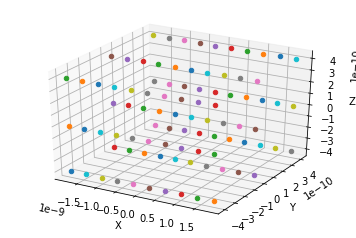

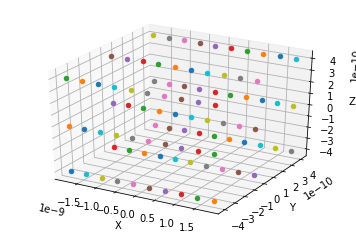

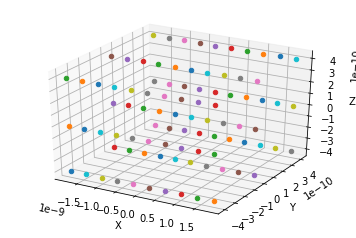

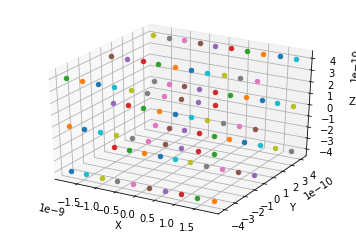

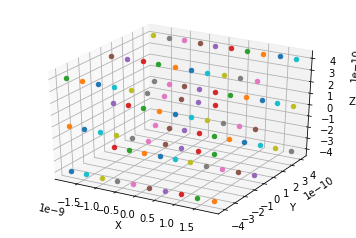

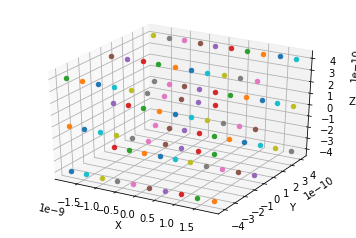

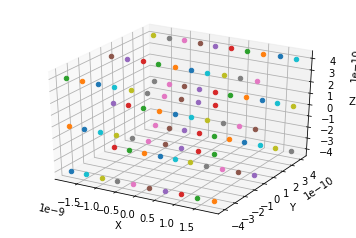

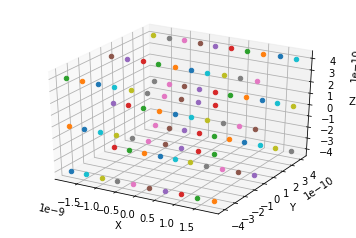

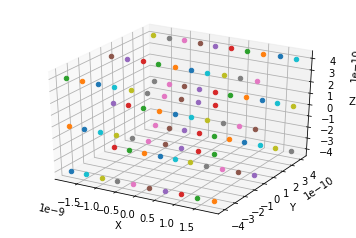

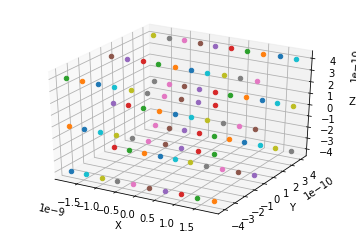

In [39]:
for time in range(N_steps):
    fig0 = plt.figure()
    ax = fig0.add_subplot(111, projection='3d')
    for i in time_grid[time,:,0,0,0]:
        for j in time_grid[time,0,:,0,1]:
            for k in time_grid[time,0,0,:,2]:
                ax.scatter(i,j,k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [40]:
def timeForceMeanAndTimeStress():
    time_forceMean = np.zeros([N_steps, 3])
    time_stress = np.zeros([N_steps, 3])
    time_stress_applied = np.zeros([N_steps, 3])
    fxMean = 0;fyMean = 0;fzMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    fxMean+=force_grid[t][i][j][k][0]
                    fyMean+=force_grid[t][i][j][k][1]
                    fzMean+=force_grid[t][i][j][k][2]
        fxMean = fxMean/N[0];fyMean = fyMean/N[1];fzMean = fzMean/N[2];
        time_stress[t] = np.array([fxMean/(N[1]*N[2]*ial**2), fyMean/(N[2]*N[0]*ial**2), fzMean/(N[1]*N[0]*ial**2)])#*68
        time_forceMean[t] = np.array([fxMean, fyMean, fzMean])
        time_stress_applied[t,0] = np.array([Fa/( abs(time_grid[t,0,0,0,1] - time_grid[t,0,N[1]-1,0,1]) * abs(time_grid[t,0,0,0,2] - time_grid[t,0,0,N[2]-1,2]))])
    return time_forceMean, time_stress, time_stress_applied

In [41]:
time_forceMean, time_stress, time_stress_applied = timeForceMeanAndTimeStress()

In [42]:
time_forceMean

array([[-2.43959710e-08,  3.26473363e-08,  3.26473363e-08],
       [-2.68355681e-08,  4.35297817e-08,  4.35297817e-08],
       [-2.70795278e-08,  4.71572635e-08,  4.71572635e-08],
       [-2.71039238e-08,  4.83664241e-08,  4.83664241e-08],
       [-2.71063634e-08,  4.87694776e-08,  4.87694776e-08],
       [-2.71066073e-08,  4.89038288e-08,  4.89038288e-08],
       [-2.71066317e-08,  4.89486125e-08,  4.89486125e-08],
       [-2.71066342e-08,  4.89635404e-08,  4.89635404e-08],
       [-2.71066344e-08,  4.89685164e-08,  4.89685164e-08],
       [-2.71066344e-08,  4.89701751e-08,  4.89701751e-08]])

In [43]:
time_stress[:,0]

array([-1.66078292e+10, -1.82686121e+10, -1.84346904e+10, -1.84512982e+10,
       -1.84529590e+10, -1.84531251e+10, -1.84531417e+10, -1.84531433e+10,
       -1.84531435e+10, -1.84531435e+10])

In [44]:
strainXYZ = np.zeros([N[0], N[1], N[2], 3])
time_strainXYZ = np.zeros([N_steps, N[0], N[1], N[2], 3])
time_strainXYZ[0] = strainXYZ
for t in range(N_steps):
    if t==0:
        pass #strainX[t] = 0
    else:
        strainXYZ = abs(time_grid[t]-time_grid[0])/ial
        time_strainXYZ[t] = strainXYZ

In [45]:
#time_strainMean = np.zeros([N_steps, 3])

In [46]:
def timeStrainMean():
    time_strainMean = np.zeros([N_steps, 3])
    StrainXMean = 0;StrainYMean = 0;StrainZMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    StrainXMean+=time_strainXYZ[t][i][j][k][0]
                    StrainYMean+=time_strainXYZ[t][i][j][k][1]
                    StrainZMean+=time_strainXYZ[t][i][j][k][2]
        StrainXMean = StrainXMean/N[0];StrainYMean = StrainYMean/N[1];StrainZMean = StrainZMean/N[2];
        time_strainMean[t] = np.array([StrainXMean, StrainYMean, StrainZMean])
    return time_strainMean

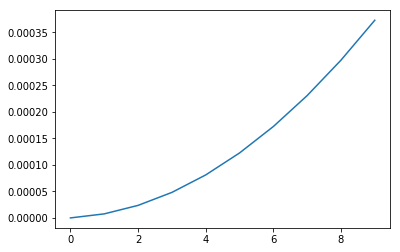

In [47]:
time_strainMean = timeStrainMean()
plot(range(N_steps) ,time_strainMean[:,0])

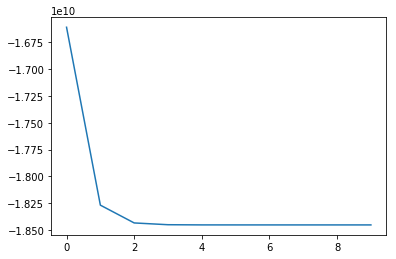

In [48]:
plot(range(N_steps) ,time_stress[:,0])

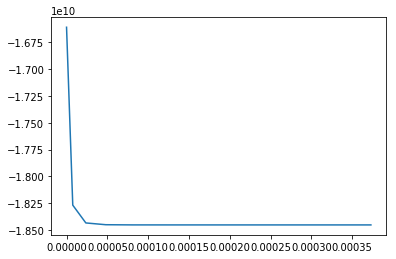

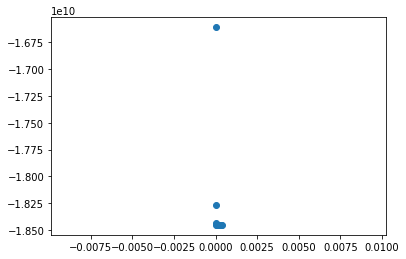

In [49]:
n=N_steps
#fig, axs = plt.subplot(1,2)

plot(time_strainMean[:n,0], time_stress[:n,0])
plt.show()
scatter(time_strainMean[:n,0], time_stress[:n,0])
plt.show()

In [50]:
for i in range(N_steps):
    print( (time_stress[i][0]/time_strainMean[i][0])/1e9,"GPa")

-inf GPa
-2395816.956270574 GPa
-779870.0356188678 GPa
-383482.5872952903 GPa
-227635.49312150877 GPa
-150656.76659728886 GPa
-107050.50428594166 GPa
-79972.4600371309 GPa
-62010.28064052967 GPa
-49486.46523997577 GPa


/home/krish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [51]:
time_stress_applied

array([[2.25000000e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25000048e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25000145e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25000291e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25000484e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25000727e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25001017e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25001356e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25001744e+08, 0.00000000e+00, 0.00000000e+00],
       [2.25002180e+08, 0.00000000e+00, 0.00000000e+00]])

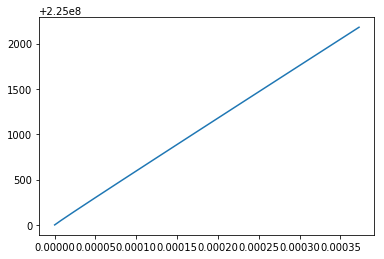

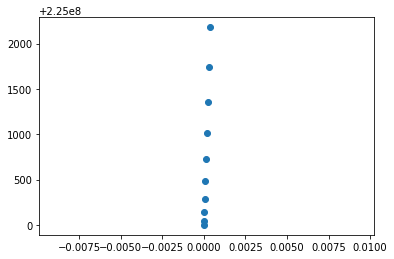

224999999.99999997 0.0 inf GPa
225000048.4361122 7.6252119459692165e-06 29507.38288068833 GPa
225000145.30838355 2.3638157032504553e-05 9518.51470480497 GPa
225000290.6169079 4.8115087379065717e-05 4676.2939209542565 GPa
225000484.36182606 8.106362819759871e-05 2775.6034286223953 GPa
225000726.54332557 0.00012248454200929792 1836.9724281309354 GPa
225001017.1616412 0.00017237790506628307 1305.2775938721577 GPa
225001356.21705437 0.0002307437249937663 975.1136514032307 GPa
225001743.70989355 0.00029758200255426817 756.0999717006118 GPa
225002179.6405342 0.00037289273782404133 603.3965181341424 GPa


/home/krish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [52]:
n=N_steps
#fig, axs = plt.subplot(1,2)

plot(time_strainMean[:n,0], time_stress_applied[:n,0])
plt.show()
scatter(time_strainMean[:n,0], time_stress_applied[:n,0])#/1e-14)
plt.show()
for i in range(n):
    print( time_stress_applied[i,0], time_strainMean[i,0], (time_stress_applied[i][0]/time_strainMean[i][0])/1e9,"GPa")

In [53]:
time_strainMean

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.62521195e-06, 4.55416058e-06, 4.55416058e-06],
       [2.36381570e-05, 1.51805353e-05, 1.51805353e-05],
       [4.81150874e-05, 3.23851419e-05, 3.23851419e-05],
       [8.10636282e-05, 5.63366531e-05, 5.63366531e-05],
       [1.22484542e-04, 8.70912930e-05, 8.70912930e-05],
       [1.72377905e-04, 1.24667803e-04, 1.24667803e-04],
       [2.30743725e-04, 1.69072431e-04, 1.69072431e-04],
       [2.97582003e-04, 2.20307258e-04, 2.20307258e-04],
       [3.72892738e-04, 2.78372979e-04, 2.78372979e-04]])

In [54]:
import platform
platform.system()
if(platform.system()=='Windows'):
    import winsound
    duration = 1000  # millisecond
    freq = 440  # Hz
    winsound.Beep(freq, duration)
if(platform.system()=='Linux'):
    import os
    os.system('spd-say "your program is finished"')


In [55]:
print("------------end------------")

------------end------------
